In [2]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from src.features.build_features import MostFrequentImputer, load_data, add_bucket, set_title

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data 

In [18]:
# train data 
train_data = load_data("train.csv")
y_train = train_data["Survived"]

# test data
test_data = load_data("test.csv")

# Transform data

## Add new columns

In [19]:
relatives = ['SibSp' ,'Parch']

def add_columns(df):
    df['family'] = df[relatives].sum(axis=1)
    df['traveling_alone'] = np.where(df['family']==0,1,0)
    df['Age_Bucket'] = add_bucket(df['Age'], bins=6)
    df['Fare_Bucket'] = add_bucket(df['Fare'], bins=6)
    df['Title'] = df['Name'].apply(set_title)
    df['name_length'] = df['Name'].apply(len)
    df['Cabin'] = df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    return df


train_data = add_columns(train_data)
test_data = add_columns(test_data)

Sex works better as category than converting to 0 and 1 

In [20]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,traveling_alone,Age_Bucket,Fare_Bucket,Title,name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,1,0,1.0,0,Mr,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,1,0,4.0,5,Mrs,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,1,2.0,1,Miss,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,1,0,4.0,5,Mrs,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,1,4.0,1,Mr,24


## Pipelines

In [22]:
# numerical pipeline
num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [23]:
# categorical pipeline 
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [24]:
# Full pipeline 
cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone', 'Cabin']
num_attribs = [ "family", 'name_length']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

# Test models

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)

In [26]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")

In [27]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state=42, solver= 'liblinear' )

In [29]:
ada_clf = AdaBoostClassifier()

In [30]:
xgb_clf = GradientBoostingClassifier(random_state=42)

In [31]:
models = [knn_clf, svm_clf,  log_clf, ada_clf, forest_clf, xgb_clf]
# train models
scores = []
for model in models:
    scores.append(cross_val_score(model, X_train, y_train, cv=10))

In [32]:
labels = ['KNN', 'SVM', 'Log Reg', 'Ada Boost', "Random Forest", 'Gradient Boosting']
mean_scores = [score.mean() for score in scores]
pd.DataFrame({'models': labels, 'scores':mean_scores}).set_index('models')

,scores
models,
KNN,0.773303
SVM,0.806924
Log Reg,0.806936
Ada Boost,0.802441
Random Forest,0.787949
Gradient Boosting,0.809184


## Plot the Classifiers scores 

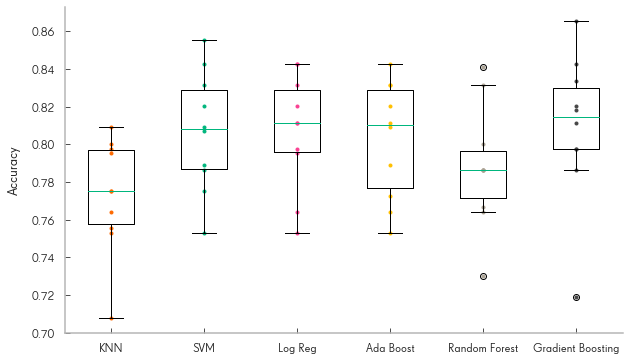

In [33]:
plt.figure(figsize=(10, 6))

# create scatter points 
for i, score in enumerate( scores, start=1): 
    plt.plot([i]*10, score, ".")

plt.boxplot(scores, labels=labels)
plt.ylabel("Accuracy", fontsize=14)
#plt.xlim(-.5,5.5)
#plt.ylim(.5,1)
plt.show()

# Tune final model 

In [36]:
param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=10),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20bfa9b0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20ba09b0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [37]:
# rename classifier 
xgb_clf = rnd_search.best_estimator_

## inspect hyperparameters

In [38]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('score: \t {}  \t \t {}'.format(round(np.sqrt(-mean_score),4 ) , params))


score: 	 0.4444  	 	 {'n_estimators': 436, 'max_features': 7}
score: 	 0.4264  	 	 {'n_estimators': 189, 'max_features': 8}
score: 	 0.4224  	 	 {'n_estimators': 103, 'max_features': 5}
score: 	 0.4303  	 	 {'n_estimators': 215, 'max_features': 3}
score: 	 0.4381  	 	 {'n_estimators': 373, 'max_features': 8}
score: 	 0.4406  	 	 {'n_estimators': 360, 'max_features': 4}
score: 	 0.4264  	 	 {'n_estimators': 131, 'max_features': 8}
score: 	 0.4368  	 	 {'n_estimators': 309, 'max_features': 6}
score: 	 0.4251  	 	 {'n_estimators': 344, 'max_features': 2}
score: 	 0.4368  	 	 {'n_estimators': 386, 'max_features': 6}


In [39]:
# retrieve categorical attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

['x0_1',
 'x0_2',
 'x0_3',
 'x1_C',
 'x1_Q',
 'x1_S',
 'x2_0.0',
 'x2_1.0',
 'x2_2.0',
 'x2_3.0',
 'x2_4.0',
 'x2_5.0',
 'x3_0',
 'x3_1',
 'x3_2',
 'x3_3',
 'x3_4',
 'x3_5',
 'x4_Miss',
 'x4_Mr',
 'x4_Mrs',
 'x4_Prestige',
 'x5_female',
 'x5_male',
 'x6_0',
 'x6_1',
 'x7_0',
 'x7_1']

In [40]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.05155673, 0.06311063, 0.02308788, 0.01879099, 0.07825884,
       0.00648997, 0.00741089, 0.01233639, 0.0146546 , 0.003683  ,
       0.0057307 , 0.00413358, 0.00474182, 0.01264252, 0.00759445,
       0.00758302, 0.00330963, 0.00256239, 0.00751123, 0.01021469,
       0.04209813, 0.08134566, 0.04496212, 0.01709813, 0.07171943,
       0.29906933, 0.00828379, 0.00442272, 0.03878999, 0.04680674])

In [41]:
trained_columns = num_attribs + cat_attribs_encoded
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.2990693347376606, 'x5_male'),
 (0.08134565778530799, 'x4_Mr'),
 (0.07825884422445885, 'x0_3'),
 (0.07171943093141432, 'x5_female'),
 (0.06311063021840412, 'name_length'),
 (0.05155672738806354, 'family'),
 (0.04680673557845822, 'x7_1'),
 (0.04496212197127981, 'x4_Mrs'),
 (0.04209813061618553, 'x4_Miss'),
 (0.03878998917494854, 'x7_0'),
 (0.02308787541590571, 'x0_1'),
 (0.01879098566677215, 'x0_2'),
 (0.017098126263038457, 'x4_Prestige'),
 (0.01465460370058644, 'x2_0.0'),
 (0.012642515034989773, 'x2_5.0'),
 (0.012336394898202754, 'x1_S'),
 (0.010214689162656046, 'x3_5'),
 (0.00828378589244676, 'x6_0'),
 (0.007594449732448813, 'x3_0'),
 (0.007583024667129323, 'x3_1'),
 (0.00751123318329455, 'x3_4'),
 (0.007410889042122717, 'x1_Q'),
 (0.006489968475455233, 'x1_C'),
 (0.0057306973009506905, 'x2_2.0'),
 (0.004741823217653065, 'x2_4.0'),
 (0.004422724664438805, 'x6_1'),
 (0.004133581453896215, 'x2_3.0'),
 (0.003683003106876984, 'x2_1.0'),
 (0.0033096347324512174, 'x3_2'),
 (0.00256239176

In [42]:
xgb_clf.score(X_train, y_train)

0.8619528619528619

In [43]:
xgb_params = xgb_clf.get_params()

## Model metrics

### ROC curve 

In [44]:
y_probas=xgb_clf.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [45]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

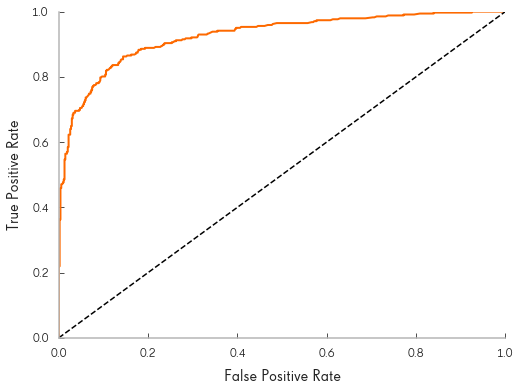

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()



In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.9257368527572727

In [48]:
y_train_pred = xgb_clf.predict(X_train)
precision_score(y_train, y_train_pred)

0.8476190476190476

In [49]:
recall_score(y_train, y_train_pred)

0.7807017543859649

In [50]:
# f1 score 
f1_score(y_train, y_train_pred)

0.8127853881278538

### Precision recall curve

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

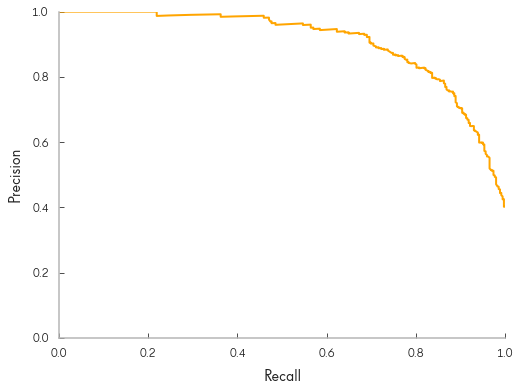

In [52]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "orange", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Create prediction file 

In [ ]:
X_test = full_pipeline.transform(test_data)

In [ ]:
# load test data 
from sklearn.externals import joblib
X_test = joblib.load( 'data/processed/X_test.pkl')

In [ ]:
test_data['Survived'] = xgb_clf.predict(X_test)

In [ ]:
submission = test_data[['PassengerId', 'Survived']]

In [ ]:
# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)